# Weight regression

### Libraries and Variables

In [1]:
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as nnf
from tqdm import tqdm
import numpy as np
from torchinfo import summary
import pandas as pd
import random
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import os
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

home_dir = os.path.expanduser('~')
raw_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/raw_data')
output_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/output_data')

### Overview

In this notebook, you will use a convolutional neural network to predict the weight of pigs using depth images. In principle, this notebook reproduces methodology from the following paper: https://www.sciencedirect.com/science/article/pii/S0168169921000740 \
You will see that applied problems can sometimes be successfully tackled with standard architectures and training procedures.


### Data exploration

Let's first have a look at the data. The csv files have as the first column the weight of a pig and as the second column a folder name. \
images_base_dir contains folders with these names where multiple frames of a video recording of the respective pig are located. The videos were recorded with a *depth measuring* camera. \
Explore the csv data:
* How many training and validation samples do we have?
* What is the mean, standard deviation, maximum and minimum of the weights?
* Hint: all of these metrics can be obtained by built in methods of the pandas dataframe

In [ ]:
# tabular data
train_weights_path = os.path.join(raw_data_dir, '5_weight_regression/train.csv')
val_weights_path = os.path.join(raw_data_dir, '5_weight_regression/val.csv')
train_weights = pd.read_csv(train_weights_path)
val_weights = pd.read_csv(val_weights_path)

# images directory
images_base_dir = os.path.join(raw_data_dir, '5_weight_regression/images')

# look at the data frame
print(train_weights.head())

######### YOUR CODE HERE:
# explore csv data
print('\n')
print(f'number of training examples: {train_weights.shape[0]}')
print(f'mean training weight: {train_weights.weight.mean()}')
print(f'std of the training weight: {train_weights.weight.std()}')
print(f'variance of the training weight: {train_weights.weight.var()}')
print(f'min training weight: {train_weights.weight.min()}')
print(f'max training weight: {train_weights.weight.max()}')
print('\n')
print(f'number of validation examples: {val_weights.shape[0]}')
print(f'mean validation weight: {val_weights.weight.mean()}')
print(f'std of the validation weight: {val_weights.weight.std()}')
print(f'variance of the validation weight: {val_weights.weight.var()}')
print(f'min validation weight: {val_weights.weight.min()}')
print(f'max validation weight: {val_weights.weight.max()}')

Let's now take a look at the pig images of one example pig. For this, we just obtain the images_folder of, say the fifth row of the train dataframe, and generate a list of all frame names that are located in this folder. We then sort it (you do not have to worry about this) to plot the images in the right temporal order to recreate the video. In the resulting plot you can see the temporal progression. Looking at the images, you can already infer a lot about the data.
* How many channels do the images have? (you can also verify this if you want by converting the images to numpy arrays or tensors)
* How is depth encoded in these images?


######### YOUR ANSWER HERE:
* We can see that the colors of the image require multiple channels as they have different shades of e.g. blue and red. Judging from the colors the images are most likely encoded with RGB values.
* We can see that the gradient from shallow to deep is represented by a gradient from blue to red.

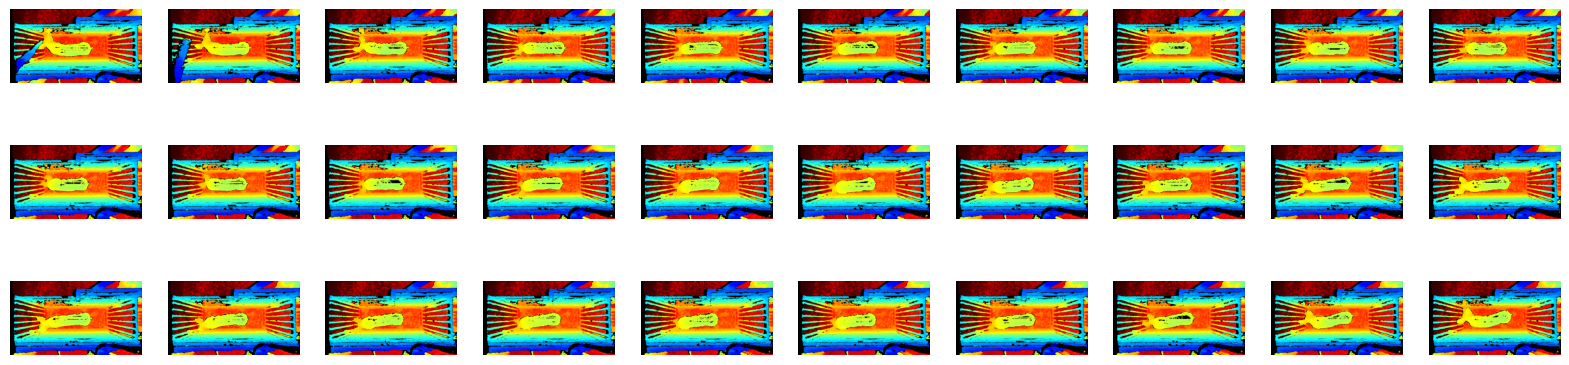

In [13]:
# plot frames of one pig
index = 5
images_one_pig_dir = os.path.join(images_base_dir, train_weights['images_folder'][index])
images_one_pig = os.listdir(images_one_pig_dir)
images_one_pig = sorted(images_one_pig, key=lambda x: int(x[:-4].split('_')[-1]))

n_rows = 3
n_cols = 10
figsize = (20, 5)
fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
axs = axs.ravel()

for i in range(n_rows * n_cols):
    if i < len(images_one_pig):
        img_path = os.path.join(images_one_pig_dir, images_one_pig[i])
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off') 
    else:
        axs[i].axis('off')

plt.show()

In [ ]:
# By converting the image to a tensor, we can verify what we already see in the plotted images: They are encoded with three channels (specificlly in the RGB format)
img_path = os.path.join(images_one_pig_dir, images_one_pig[0])
image = Image.open(img_path)
image = transforms.ToTensor()(image)
print(image.shape)
image

### Dataset

Let's now create a Pytorch dataset that loads the images together with the corresponding weight label. This is the first time that the data we have is, so to say, "distributed" across different locations (the labels are saved in the csv while the images are somewhere else). However, this is no problem for the Pytorch dataset. You can just pass all the information required to the constructor and then perform all the operations needed to load the images in the getitem function. Do the following:

* Pass the weights dataframe (or the path to it) and the images_base_dir to the constructor.
* As always, the getitem function gets called with an index as an argument. You can use it to index the dataframe and get the corresponding weight and image folder.
* Since there are many images in a single image folder (as we saw above), it might be helpful for training heterogeneity to randomly select one of these images.
* Then you can load the image using the ``Image.open()``function.

In [ ]:
class WeightDataset(Dataset):
    ######### YOUR CODE HERE:
    def __init__(self, weights_df_path, images_base_dir):
        self.weights_df = pd.read_csv(weights_df_path)
        self.images_base_dir = images_base_dir
        self.transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

    def __getitem__(self, i):
        # select row from dataframe and get data from it
        info = self.weights_df.iloc[i, :]
        weight = torch.tensor(info.weight).float()
        images_folder = info.images_folder

        # load one random image corresponding to the weighting of the selected row
        images_dir = os.path.join(self.images_base_dir, images_folder)
        image_name = random.choice(os.listdir(images_dir))
        image_path = os.path.join(images_dir, image_name)
        image = Image.open(image_path)

        # transform and return image
        image = self.transform(image)
        return image, weight

    def __len__(self):
        return len(self.weights_df)

### Model

Now it is time to define the model. We can make use of pre-trained models that are publicly available with torchvision and adapt them from our purposes. This way we can make use of the already learned features to have faster convergence and sometimes also better performance, especially when training datasets are small. One popular architecture is resnet. In torchvision, you can get different resnet sizes from torchvision.models.

In [23]:
model = resnet18(weights=ResNet18_Weights.DEFAULT) # load resnet pre-trained on imagenet

Let's look at the model structure using summary! Does the model already have the right output structure? We want to predict the weight. So we want a single output unit.

######### YOUR ANSWER HERE \
No, the output of the model has 1000 elements (since imagenet has 1000 classes)

In [ ]:
summary(model, input_size=(1, 3, 240, 426))

If the model does not have the correct output structure, you need to modify it accordingly. Using the following code you can see the name of the parameters or modules of the model. In contrast to the summary function that displays the class names of the modules (e.g. "Linear" for nn.Linear), model.named_modules return the actual names of the modules within the model object (e.g. "fc" if you set self.fc = nn.Linear(512, 1)). You can use this information to *access/modify/replace* these modules as you would always do with attributes of an object. model.named_parameters only shows those attributes of the model that are parameterized (e.g. a linear layer has parameters while the relu function does not have any parameters)

In [ ]:
for name, param in model.named_parameters():
    print(name)

In [ ]:
for name, param in model.named_modules():
    print(name)

Go ahead and try modifying the model so that it can be used for the prediction task at hand. Hint: You will not need to change much!

In [ ]:
class WeightModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)
        ######### YOUR CODE HERE:
        self.resnet18.fc = nn.Linear(512, 1)
        self.resnet18.fc.bias.data.fill_(55) # initialize bias to the mean of the training pig weights

    def forward(self, x):
        x = self.resnet18(x).squeeze() # squeeze important for the loss function
        return x

### training loop

The training functions can be taken basically without modifications from the MLP exercise:

In [ ]:
def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(trainloader)


def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nnf.mse_loss(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(valloader)

The training loop is also the same in principle. Two new things were added: 
1) Here we try out a learning rate scheduler, specifically the ReduceLROnPlateau scheduler. It checks whether the validation loss did not increase for a specified number of epochs and, if not, decrease the learning rate by a specified factor.
2) In addition to the state_dict, we print and save the metrics (train loss, val loss and also the learning rate) after every epoch to a pickle file (csv would also be possible). This is usually recommended since trainings in practice can take hours or days and you do not want to lose all the information in case something crashes. This training will also take a little longer than the ones from the previous exercises.

Start the training procedure now:

* Monitor the training loss. Compare it with the variance of the weight in the training dataset. Does the value reduce to a reasonable value after a couple of epochs? 
* If not, abort the training and think about potential reasons.

Hints: 
* Newly initialized layers will get weights that are randomly distributed around zero. Given this, what is the expected prediction of the network when it has not yet been trained? 
* What could we change to influence the initial prediction in a favorable way given that the linear layer is defined as $output = w_1 \cdot x_1 + w_2 \cdot x_2 + ... + w_n \cdot x_n + bias$

######### YOUR ANSWER HERE \
Since the weights of the final linear layer are randomly initialized around zero, the expected prediction at the beginning of training is also zero. This is very far off from the mean weight which is roughly 55. The initially expected mean squared error therefore is very high (roughly 50 * 50 = 2500). This can lead to unstable and large gradients. Intuitively, one could say that the network is so far off that it does not really know how to adjust its parameters. The network might even not converge at all in some cases! We can help out by setting the bias to the mean of the dataset at the beginning of training (see model definition of the solution).



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The model is running on {device}.")

# training parameters
epochs = 120
lr = 0.001
batch_size = 128
print_interval = 1 ### print loss every print_interval epochs
decay_factor = 0.1 ### factor to reduce learning rate
patience = 20 ### number of epochs to wait before reducing learning rate

# save best model state dict and metrics
save_dir_state_dict = os.path.join(output_data_dir, '5_weight_regression')
os.makedirs(save_dir_state_dict, exist_ok=True)
save_path_state_dict = os.path.join(save_dir_state_dict, 'best.pth')
save_path_metrics = os.path.join(save_dir_state_dict, 'metrics.pkl')

# instantiate dataset and dataloader
train_weights_path = os.path.join(raw_data_dir, '5_weight_regression/train.csv')
val_weights_path = os.path.join(raw_data_dir, '5_weight_regression/val.csv')
images_base_dir = os.path.join(raw_data_dir, '5_weight_regression/images')
trainset = WeightDataset(train_weights_path, images_base_dir)
valset = WeightDataset(val_weights_path, images_base_dir)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)    

# Initialize model, optimizer and scheduler
model = WeightModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=decay_factor, patience=patience)

# train loop
train_losses = []
val_losses = []
min_val_loss = float('inf')
for epoch in tqdm(range(epochs)):
    train_loss = train_one_epoch(model, trainloader, optimizer, device)
    train_losses.append(train_loss)
    
    val_loss = validate(model, valloader, device)
    scheduler.step(val_loss)
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), save_path_state_dict)
        min_val_loss = val_loss
        
    if epoch % print_interval == 0:
        print(f'Epoch {epoch} - train loss: {train_loss:.3f} - val loss: {val_loss:.3f} - lr: {optimizer.param_groups[0]["lr"]:.6f}')
    
    metrics = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'lr': optimizer.param_groups[0]['lr']
    })
    metrics.to_pickle(save_path_metrics)

### results

Let's now look at the results. For the loss curves, we can use the same functions as before. Since the loss might be very high at the start of training, it might be useful to clip the ylim of the plot.

In [ ]:
results = pd.read_pickle(save_path_metrics)

####################### plot losses
# plt.ylim([0,50])
plt.plot(np.linspace(1, epochs, epochs), results['train_loss'], c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), results['val_loss'], c='red', label='Validation Loss')

# Mark the minimum validation loss
index = np.argmin(results['val_loss'])
plt.plot(index+1, results['val_loss'][index], 'kx', label='Min Validation Loss', markersize=12)

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's now plot figure 8 from the paper. 
* Get all predictions and ground truths on the validation dataset using the best model.
* Note that there will be some variability in the predictions in case you randomly sample an image for each pig.
* Plot the results in the same way as in the paper.
* also calculate the mean squared error given all the predictions and ground truths. It should be similar to the best validation loss.

In [ ]:
val_weights_path = os.path.join(raw_data_dir, '5_weight_regression/val.csv')
images_base_dir = os.path.join(raw_data_dir, '5_weight_regression/images')

# dataset and trained model
valset = WeightDataset(val_weights_path, images_base_dir)
valloader = DataLoader(valset, batch_size=1)
model = WeightModel()
best_ckpt = torch.load(save_path_state_dict)
model.load_state_dict(best_ckpt)
model = model.to(device)
model.eval()

In [ ]:
######### YOUR CODE HERE:

all_preds = []
all_targets = []
with torch.no_grad():
    for image, target in tqdm(valloader):
        image = image.to(device)
        pred = model(image)
        all_preds.append(pred.item())
        all_targets.append(target.item())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

plt.scatter(all_targets, all_preds)
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

# Plot reference line for perfect prediction
min_val = min(min(all_targets), min(all_preds))
max_val = max(max(all_targets), max(all_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()

In [ ]:
# calculate the mean squared error (should give comparable results to the validation loss)
mse = np.mean((all_targets - all_preds) ** 2)
print(f'Mean Squared Error: {mse}')

### Bonus (advanced): defining a resnet by yourself

Instead of modifying the torchvision implementation of a resnet, you can also define your own resnet. Take a look at the original paper if you want: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

1) Start by implementing the `BasicBlock` (basic residual block) described in the paper
* It consists of two convolutional layers and a residual connection.
* Of course batch norm and relu need to be added in the right places
* A residual connection using a pure identity function is in general not possible since the number of channels usually changes with the convolutions. A projection of each pixel in the input feature map to the respective dimension is what comes closest to a pure identity. This can be implemented as a convolution with kernel size 1x1.
* Also implement a downsampling using MaxPool2d conditional on a boolean downsample argument. Downsample by a factor of 2.
* If no downsampling is performed, the output should have the same width height dimensions, so add appropriate padding.

2) Then implement a ``Block`` module that combines two `BasicBlock` modules.
* The second basic block should downsample.

3) Finally, implement the ``ResNet``
* It should (I) apply multiple ``Block`` modules, (II) pool the final resulting feature map and (III) apply a fully connected layer.

It should be noted that the resulting model will most likely perform worse than the torchvision model (I obtained a validation mse of roughly 10). This is probably due to a better implementation of the torchvision model and the pretrained weights.

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        ######### YOUR CODE HERE:
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.identity = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if downsample:
            self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            self.downsample = None
        
    def forward(self, x):
        identity = self.identity(x)
        x = nnf.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += identity
        x = nnf.relu(x)
        
        if self.downsample:
            x = self.downsample(x)
        return x

class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        ######### YOUR CODE HERE:
        self.block1 = BasicBlock(in_channels, out_channels)
        self.block2 = BasicBlock(out_channels, out_channels, downsample=True)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block_channels, output_size):
        super().__init__()
        ######### YOUR CODE HERE:
        
        # blocks
        blocks = []
        for i in range(len(block_channels) - 1):
            blocks.append(Block(block_channels[i], block_channels[i+1]))
        self.blocks = nn.Sequential(*blocks)
        
        # output layer
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(block_channels[-1], output_size)
        self.fc.bias.data.fill_(55) # initialize bias to the mean of the training pig weights
        
    def forward(self, x):
        x = self.blocks(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1) # equivalent to squeezing but maybe nice to see some alternative code :)
        x = self.fc(x)
        return x         
    
    
model = ResNet([3, 32, 64, 128, 256], 1)